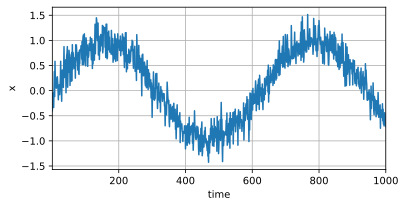

In [9]:
%matplotlib inline
from d2l import torch as d2l
import torch
import torch.nn as nn

# 生成1000个点
T = 1000
time = torch.arange(1, T+1, dtype=torch.float32)

x = torch.sin(0.01 * time)+ torch.normal(0, 0.2, [T,])
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))
x2 =torch.normal(0,0.02,[T],)

In [2]:
x2.shape

torch.Size([1000])

In [3]:
'''
滑动窗口
y(t) = x(t)     x(t)=[x(t-r),....,x(t-1)]
'''
#  前四个数据没有足够长的历史数据，所以生成的数据为996条 即 996*4
tau = 4#滑动窗口大小为4
features = torch.zeros((T -tau), tau)
for i in range(4):
    features[:, i] = x[i: T - tau + i]#广播？
#  features[:,0] = x[0: 1000-4+0] 第一列数据 对features第一列进行操作 996*1  等于序列从0-T-4+0（0-996）
#  features[:,1] = x[1: 1000-4+1]
#  features[:,2] = x[0: 1000-4+2]
#  features[:,3] = x[0: 1000-4+3]
# label = [4:1000]     (-1,1)自动另一个维度推断出来 (996*1)
labels = d2l.reshape(x[tau:], (-1,1))

batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [4]:
# 初始化网络权重
def init_weights(m):
    if type(m) ==nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)# Glorot initialization

# 简单的MLP
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10,1))
    net.apply(init_weights)
    return net

# Square loss
loss = nn.MSELoss()


In [5]:
# 训练模型
def train(net, train_iter, loss, epochs, lr):
    optim = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            optim.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optim.step()
        print(f'epoch {epoch + 1},'
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1,loss: 0.055266
epoch 2,loss: 0.051104
epoch 3,loss: 0.049102
epoch 4,loss: 0.047902
epoch 5,loss: 0.047108


D:\software\anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  after removing the cwd from sys.path.


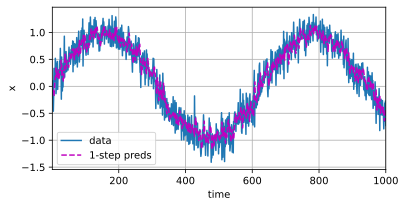

In [6]:
# 做预测
'''

'''
onestep_pred = net(features)
d2l.plot([time, time[tau:]], [d2l.numpy(x), d2l.numpy(onestep_pred)],'time','x',
                              legend=['data','1-step preds'], xlim=[1,1000],figsize=(6, 3))

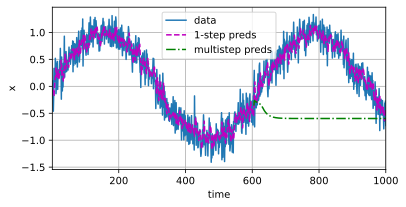

In [7]:
'''
多步预测
x_(605) = f(x(601),x(602),x(603),x(604))
x_(606) = f(x(602),x(603),x(604),x_(605))
用前一步的预测值做下一个时间的预测
'''
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[:n_train + tau]
#
for i in range(n_train + tau, T):
    multistep_preds[i] = d2l.reshape(net(
        multistep_preds[i - tau: i].reshape(1, -1)), 1)

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [d2l.numpy(x), d2l.numpy(onestep_pred),
          d2l.numpy(multistep_preds[n_train + tau:])], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

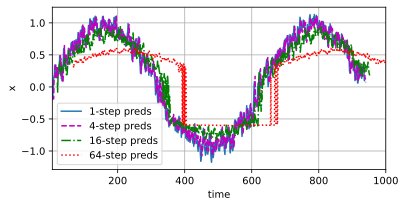

In [8]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# Column `i` (`i` < `tau`) are observations from `x` for time steps from
# `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1].T

# Column `i` (`i` >= `tau`) are the (`i - tau + 1`)-step-ahead predictions for
# time steps from `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i] = d2l.reshape(net(features[:, i - tau: i]), -1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [d2l.numpy(features[:, tau + i - 1]) for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))